In [1]:
#importing the libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from efficientnet.keras import center_crop_and_resize

C:\Users\chethan\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# Update the file path
path = 'C:\\Users\\chethan\\Downloads\\RIC\\Image dataset\\'
file = os.path.join(path, 'labels.csv')
# Load the dataset
emotion_dataset = pd.read_csv(file)
emotion_dataset.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


In [3]:
# Data augmentation using OpenCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Map existing labels to stress levels
stress_level_mapping = {
    'anger': 'high_stressed',
    'contempt': 'low_stressed',
    'disgust': 'high_stressed',
    'fear': 'high_stressed',
    'happy': 'low_stressed',
    'neutral': 'low_stressed',
    'sad': 'high_stressed',
    'surprise': 'low_stressed'
}

In [5]:
# Add a new column 'stress_level' based on the mapping
emotion_dataset['stress_level'] = emotion_dataset['label'].map(stress_level_mapping)


In [6]:
# Adding the 'stress_level' column in your DataFrame
high_stressed_count = emotion_dataset[emotion_dataset['stress_level'] == 'high_stressed'].shape[0]
low_stressed_count = emotion_dataset[emotion_dataset['stress_level'] == 'low_stressed'].shape[0]
print("Number of High Stressed Instances:", high_stressed_count)
print("Number of Low Stressed Instances:", low_stressed_count)


Number of High Stressed Instances: 13118
Number of Low Stressed Instances: 15057


In [7]:
# Handling Missing Values
emotion_dataset.dropna(inplace=True)


In [8]:
# Remove outliers using z-score
import numpy as np
from scipy.stats import zscore
emotion_dataset = emotion_dataset[(np.abs(zscore(emotion_dataset[['relFCs']])) < 3).all(axis=1)]

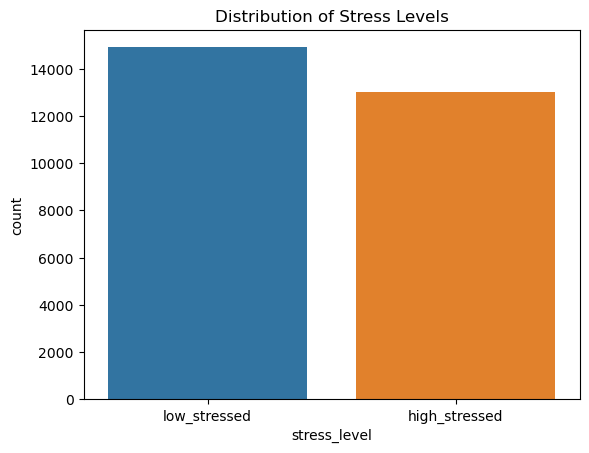

In [9]:
# Exploratory Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of stress levels
sns.countplot(x='stress_level', data=emotion_dataset)
plt.title('Distribution of Stress Levels')
plt.show()

In [10]:
# Min-Max Scaling
scaler = MinMaxScaler()
emotion_dataset[['relFCs']] = scaler.fit_transform(emotion_dataset[['relFCs']])


In [11]:
# Train-test split
X_train_features, X_test_features, y_train, y_test = train_test_split(
    emotion_dataset[['relFCs', 'pth']], emotion_dataset['stress_level'], test_size=0.2, random_state=42
)

In [12]:
# Data augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
# Reshape the data for RGB images
image_height = 96
image_width = 96
num_channels = 3  # For RGB images

In [14]:
# Load and preprocess the images for training with data augmentation
X_train_images = []
for image_path in X_train_features['pth']:
    img = load_img(os.path.join(path, image_path), target_size=(image_height, image_width))
    img_array = img_to_array(img)
    img_array = train_datagen.random_transform(img_array)
    X_train_images.append(img_array)

X_train_images = np.array(X_train_images)

In [15]:
# Load and preprocess the images for testing
X_test_images = []
for image_path in X_test_features['pth']:
    img = load_img(os.path.join(path, image_path), target_size=(image_height, image_width))
    img_array = img_to_array(img)
    X_test_images.append(img_array)

X_test_images = np.array(X_test_images)


In [16]:
# EfficientNetB0 model
def build_efficientnet_model(input_shape=(image_height, image_width, num_channels), num_classes=1):
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [17]:
# Initialize the model
model = build_efficientnet_model()

In [18]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [19]:
# Encode the target variable 'stress_level'
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [20]:
# Train the model
history = model.fit(X_train_images, y_train_encoded, epochs=10, batch_size=32,
                    validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
559/559 [==============================] - 846s 1s/step - loss: 0.6692 - accuracy: 0.6289 - val_loss: 0.5827 - val_accuracy: 0.7018
Epoch 2/10
559/559 [==============================] - 757s 1s/step - loss: 0.5065 - accuracy: 0.7527 - val_loss: 0.5456 - val_accuracy: 0.7311
Epoch 3/10
559/559 [==============================] - 798s 1s/step - loss: 0.4136 - accuracy: 0.8111 - val_loss: 0.5431 - val_accuracy: 0.7390
Epoch 4/10
559/559 [==============================] - 754s 1s/step - loss: 0.3188 - accuracy: 0.8619 - val_loss: 0.5708 - val_accuracy: 0.7475
Epoch 5/10
559/559 [==============================] - 761s 1s/step - loss: 0.2434 - accuracy: 0.8998 - val_loss: 0.6536 - val_accuracy: 0.7372
Epoch 6/10
559/559 [==============================] - 748s 1s/step - loss: 0.1785 - accuracy: 0.9295 - val_loss: 0.6970 - val_accuracy: 0.7605


In [21]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_images, y_test_encoded)
print(f'Test Accuracy: {test_acc}')


175/175 [==============================] - 56s 317ms/step - loss: 0.5047 - accuracy: 0.7591
Test Accuracy: 0.7590900659561157


In [22]:
# Make predictions
y_pred = model.predict(X_test_images)
y_pred_binary = (y_pred > 0.5).astype(int)

175/175 [==============================] - 59s 316ms/step


In [23]:
# Classification report
print(classification_report(y_test_encoded, y_pred_binary))


              precision    recall  f1-score   support

           0       0.74      0.74      0.74      2607
           1       0.77      0.78      0.77      2976

    accuracy                           0.76      5583
   macro avg       0.76      0.76      0.76      5583
weighted avg       0.76      0.76      0.76      5583



In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[1923  684]
 [ 661 2315]]


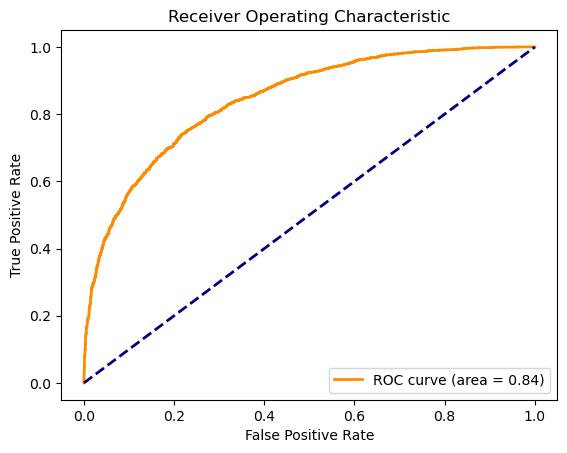

In [25]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test_encoded, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

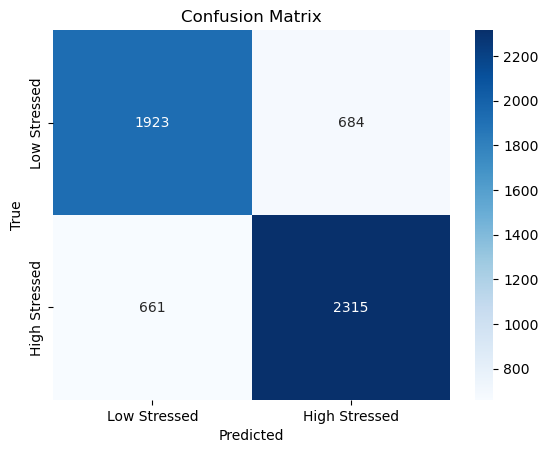

In [26]:
# Confusion Matrix Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Define the class labels
class_labels = ['Low Stressed', 'High Stressed']

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [30]:
from joblib import dump

save_path_efficientnet = 'C:/Users/chethan/Downloads/RIC/efficientnet_model.joblib'

# Save the EfficientNet model
dump(model, save_path_efficientnet)

print(f"EfficientNet model saved successfully at: {save_path_efficientnet}")

EfficientNet model saved successfully at: C:/Users/chethan/Downloads/RIC/efficientnet_model.joblib
